In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import tqdm.notebook as tq

In [23]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [1]:
data_location  = 'Dataset/'
model_location = 'Models/'

In [ ]:
classes = 4
cur_path = data_location
X, y = [], []

for i in range(classes):
    path = os.path.join(cur_path, str(i))
    images = os.listdir(path)
    labels = np.zeros(4)
    labels[i] = 1
    for a in tq.tqdm(images):
        try:
            temp = os.path.join(path, a)
            image = Image.open(temp)
            image = image.resize((30,30))
            if image.mode == 'RGBA':
                image.load() 
                background = Image.new("RGB", image.size, (255, 255, 255))
                background.paste(image, mask=image.split()[3])
                image = np.array(background)
            else:
                image = np.array(image)
            X.append(image)
            y.append(labels)
        except Exception as e:
            print(e)

In [18]:
X_tra, X_tes, y_tra, y_tes = train_test_split(X, y, test_size = 0.2, shuffle=True)

X_train = np.array(X_tra)
y_train = np.array(y_tra)
X_test = np.array(X_tes)
y_test = np.array(y_tes) 

X_train = X_train.reshape(X_train.shape[0], 30, 30, 3)
X_test = X_test.reshape(X_test.shape[0], 30, 30, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [19]:
img_size = 30
img_size_flat = 2700
img_shape = (30, 30, 3)
num_classes = 4
num_channels = 3

In [20]:
def plot_images(images, cls_true, cls_pred=None, noise=0.0):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        image = images[i].reshape(img_shape)
        image += noise
        image = np.clip(image, 0.0, 1.0)
        ax.imshow(image,
                  cmap='binary', interpolation='nearest')
        
        if cls_pred is None:
            xlabel = "True: {0}".format(np.argmax(cls_true[i]))
        else:
            xlabel = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

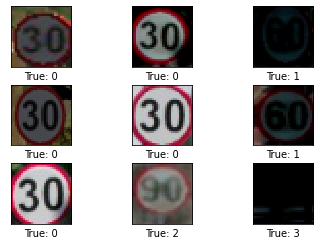

In [21]:
images = X_test[0:9]
cls_true = y_test[0:9]
# Plot the images and labels
plot_images(images=images, cls_true=cls_true)

In [24]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

noise_limit = 0.15
noise_l2_weight = 0.02

ADVERSARY_VARIABLES = 'adversary_variables'

collections = [tf.GraphKeys.GLOBAL_VARIABLES, ADVERSARY_VARIABLES]

x_noise = tf.Variable(tf.zeros([img_size, img_size, num_channels]),
                      name='x_noise', trainable=False,
                      collections=collections)
x_noise_clip = tf.assign(x_noise, tf.clip_by_value(x_noise,
                                                   -noise_limit,
                                                   noise_limit))
x_noisy_image = x_image + x_noise
x_noisy_image = tf.clip_by_value(x_noisy_image, 0.0, 1.0)

In [ ]:
# Start the network with the noisy input image.
net = x_noisy_image

# 1st convolutional layer.
net = tf.layers.conv2d(inputs=net, name='layer_conv1', padding='same',
                       filters=16, kernel_size=5, activation=tf.nn.relu)
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

# 2nd convolutional layer.
net = tf.layers.conv2d(inputs=net, name='layer_conv2', padding='same',
                       filters=36, kernel_size=5, activation=tf.nn.relu)
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

# Flatten layer.This should eventually be replaced by:
net = tf.layers.flatten(net)
# net = tf.contrib.layers.flatten(net)

# 1st fully-connected / dense layer.
net = tf.layers.dense(inputs=net, name='layer_fc1',
                      units=128, activation=tf.nn.relu)

# 2nd fully-connected / dense layer.
net = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)

# Unscaled output of the network.
logits = net

# Softmax output of the network.
y_pred = tf.nn.softmax(logits=logits)

# Loss measure to be optimized.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                           logits=logits)
loss = tf.reduce_mean(cross_entropy)

### Optimizer for Normal Training

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### Optimizer for Adversarial Noise

In [27]:
adversary_variables = tf.get_collection(ADVERSARY_VARIABLES)

In [28]:
l2_loss_noise = noise_l2_weight * tf.nn.l2_loss(x_noise)
loss_adversary = loss + l2_loss_noise

optimizer_adversary = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary, var_list=adversary_variables)

y_pred_cls = tf.argmax(y_pred, axis=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

In [29]:
session = tf.Session()

In [30]:
session.run(tf.global_variables_initializer())

In [31]:
def init_noise():
    session.run(tf.variables_initializer([x_noise]))

In [32]:
init_noise()

### Helper-function to perform optimization iterations

In [33]:
train_batch_size = 4

In [34]:
import random
def generate_batch(batch_size):
    x_batch, y_batch = [], []
    indices = random.sample(range(X_train.shape[0]), batch_size)
    for index in indices:
        x_batch.append(X_train[index].flatten())
        y_batch.append(y_train[index])
    return np.array(x_batch), np.array(y_batch)

In [35]:
def optimize(num_iterations, adversary_target_cls=None):
    start_time = time.time()

    for i in range(num_iterations):
        x_batch, y_true_batch = generate_batch(train_batch_size)

        if adversary_target_cls is not None:
            y_true_batch = np.zeros_like(y_true_batch)
            y_true_batch[:, adversary_target_cls] = 1.0
            
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        if adversary_target_cls is None:
            session.run(optimizer, feed_dict=feed_dict_train)
        else:
            session.run(optimizer_adversary, feed_dict=feed_dict_train)
            session.run(x_noise_clip)

        if (i % 100 == 0) or (i == num_iterations - 1):
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i, acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-functions for getting and plotting the noise

In [36]:
def get_noise():
    noise = session.run(x_noise)
    return np.squeeze(noise)

In [37]:
def plot_noise():
    # Get the adversarial noise from inside the TensorFlow graph.
    noise = get_noise()
    
    # Print statistics.
    print("Noise:")
    print("- Min:", noise.min())
    print("- Max:", noise.max())
    print("- Std:", noise.std())

    # Plot the noise.
    plt.imshow(noise, interpolation='nearest', cmap='seismic',
               vmin=-1.0, vmax=1.0)

### Helper-function to plot example errors

In [38]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    
    images = X_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = y_test[incorrect]
    noise = get_noise()
    
    # Plot the first 9 images.
    plot_images(images=images[0][0:9],
                cls_true=cls_true[0][0:9],
                cls_pred=cls_pred[0][0:9],
                noise=noise)

### Helper-function to plot confusion matrix

In [39]:
def plot_confusion_matrix(cls_pred):
    cls_true = y_test
    
    cls_tt = []
    for i in range(cls_true.shape[0]):
        cls_tt.append(np.argmax(cls_true[i]))
    cls_tt = np.array(cls_tt)
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_tt,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

In [40]:
X_test1 = []
for i in range(X_test.shape[0]):
    X_test1.append(X_test[i].flatten())
X_test1 = np.array(X_test1)

### Helper-function for showing the performance

In [41]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_confusion_matrix(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = X_test.shape[0]
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0
    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = X_test1[i:j, :]
        labels = y_test[i:j, :]
        feed_dict = {x: images,
                     y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    cls_true = y_test
    correct = (cls_true == cls_pred)
    corr = [1 if (cls_true == cls_pred) else 0]
    correct_sum = sum(corr)
    acc = float(correct_sum) / num_test

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [42]:
optimize(num_iterations=1000)

Optimization Iteration:      0, Training Accuracy:  25.0%
Optimization Iteration:    100, Training Accuracy:  75.0%
Optimization Iteration:    200, Training Accuracy:  50.0%
Optimization Iteration:    300, Training Accuracy:  75.0%
Optimization Iteration:    400, Training Accuracy: 100.0%
Optimization Iteration:    500, Training Accuracy: 100.0%
Optimization Iteration:    600, Training Accuracy: 100.0%
Optimization Iteration:    700, Training Accuracy: 100.0%
Optimization Iteration:    800, Training Accuracy: 100.0%
Optimization Iteration:    900, Training Accuracy: 100.0%
Optimization Iteration:    999, Training Accuracy: 100.0%
Time usage: 0:00:33


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Example errors:


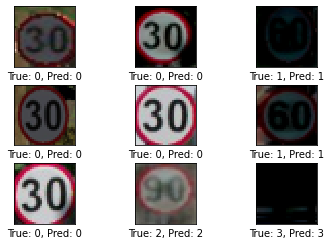

In [43]:
print_confusion_matrix(show_example_errors=True)

## Find the adversarial noise

In [44]:
init_noise()

In [45]:
optimize(num_iterations=1000, adversary_target_cls=1)

Optimization Iteration:      0, Training Accuracy:  25.0%
Optimization Iteration:    100, Training Accuracy: 100.0%
Optimization Iteration:    200, Training Accuracy: 100.0%
Optimization Iteration:    300, Training Accuracy: 100.0%
Optimization Iteration:    400, Training Accuracy: 100.0%
Optimization Iteration:    500, Training Accuracy: 100.0%
Optimization Iteration:    600, Training Accuracy: 100.0%
Optimization Iteration:    700, Training Accuracy: 100.0%
Optimization Iteration:    800, Training Accuracy: 100.0%
Optimization Iteration:    900, Training Accuracy: 100.0%
Optimization Iteration:    999, Training Accuracy: 100.0%
Time usage: 0:00:02


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Noise:
- Min: -0.15
- Max: 0.15
- Std: 0.071344316


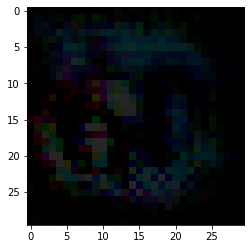

In [46]:
plot_noise()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Example errors:


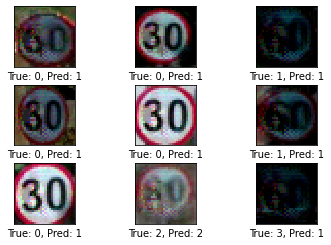

Confusion Matrix:
[[ 0 47  0  0]
 [ 0 49  0  0]
 [ 0 19  2  0]
 [ 0 46  0  1]]


In [47]:
print_confusion_matrix(show_example_errors=True, show_confusion_matrix=True)

## Adversarial noise for all target-classes

In [50]:
def find_all_noise(num_iterations=1000):
    # Adversarial noise for all target-classes.
    all_noise = []

    # For each target-class.
    for i in range(num_classes):
        print("Finding adversarial noise for target-class:", i)
        init_noise
        optimize(num_iterations=num_iterations,
                 adversary_target_cls=i)
        noise = get_noise()
        all_noise.append(noise)
        print()
    
    return all_noise

In [51]:
all_noise = find_all_noise(num_iterations=300)

Finding adversarial noise for target-class: 0
Optimization Iteration:      0, Training Accuracy:   0.0%
Optimization Iteration:    100, Training Accuracy: 100.0%
Optimization Iteration:    200, Training Accuracy: 100.0%
Optimization Iteration:    299, Training Accuracy: 100.0%
Time usage: 0:00:01

Finding adversarial noise for target-class: 1
Optimization Iteration:      0, Training Accuracy:   0.0%
Optimization Iteration:    100, Training Accuracy: 100.0%
Optimization Iteration:    200, Training Accuracy: 100.0%
Optimization Iteration:    299, Training Accuracy: 100.0%
Time usage: 0:00:01

Finding adversarial noise for target-class: 2
Optimization Iteration:      0, Training Accuracy:   0.0%
Optimization Iteration:    100, Training Accuracy: 100.0%
Optimization Iteration:    200, Training Accuracy: 100.0%
Optimization Iteration:    299, Training Accuracy: 100.0%
Time usage: 0:00:01

Finding adversarial noise for target-class: 3
Optimization Iteration:      0, Training Accuracy:   0.0%

### Plot the adversarial noise for all target-classes

In [53]:
def plot_all_noise(all_noise):
    fig, axes = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        noise = all_noise[i]
        noise = np.clip(noise, 0.0, 1.0)
        
        ax.imshow(noise,
                  cmap='seismic', interpolation='nearest',
                  vmin=-1.0, vmax=1.0)
        plt.imsave(os.path.join(data_location,'noise'+str(i)+'.png'), noise)
        ax.set_xlabel(i)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

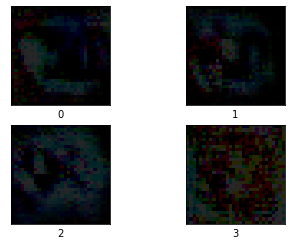

In [54]:
plot_all_noise(all_noise)

## Close TensorFlow Session

In [55]:
session.close()